# 48479853-MAHESH SAI KANDULA
## Assignment 2 - Deep Learning for Image Classification

### Task 1 - Data exploration and preparation

Loading and checking all the csv files(train,test and devtest)

In [1]:
import pandas as pd

df_train = pd.read_csv("train.csv")

# This is used inorder to understand the structure
print("The columns in train csv file", df_train.columns.tolist())
print("\n Rows of train.csv:")
print(df_train.head())

The columns in train csv file ['path', 'label']

 Rows of train.csv:
                  path  label
0  paper/paper_770.png  paper
1  paper/paper_721.png  paper
2   paper/paper_47.png  paper
3  paper/paper_476.png  paper
4  paper/paper_218.png  paper


In [2]:
df_test = pd.read_csv("test.csv")

# This is used inorder to understand the structure
print("The columns in test csv file", df_test.columns.tolist())
print("\n Rows of test.csv:")
print(df_test.head())

The columns in test csv file ['path', 'label']

 Rows of test.csv:
                        path     label
0        paper/paper_343.png     paper
1          rock/rock_697.png      rock
2        paper/paper_489.png     paper
3  scissors/scissors_764.png  scissors
4  scissors/scissors_251.png  scissors


In [3]:
df_devtest = pd.read_csv("devtest.csv")

# This is used inorder to understand the structure
print("The columns in devtest csv file", df_devtest.columns.tolist())
print("\n Rows of devtest.csv:")
print(df_devtest.head())

The columns in devtest csv file ['path', 'label']

 Rows of devtest.csv:
                        path     label
0          rock/rock_353.png      rock
1  scissors/scissors_211.png  scissors
2          rock/rock_198.png      rock
3   scissors/scissors_37.png  scissors
4          rock/rock_605.png      rock


In [4]:
import cv2
from collections import Counter

# This is used to define the root directory where all the folders of rock,paper and scissors are stored
root_directory = "archive"

# Dictionary of datasets 
datasets = {
    "train": df_train,
    "devtest": df_devtest,
    "test": df_test
}

In [5]:
import matplotlib.pyplot as plt



<--- TRAIN SET --->
-->train, Class: paper, Image: archive/paper/paper_770.png, Shape: (300, 300, 3)


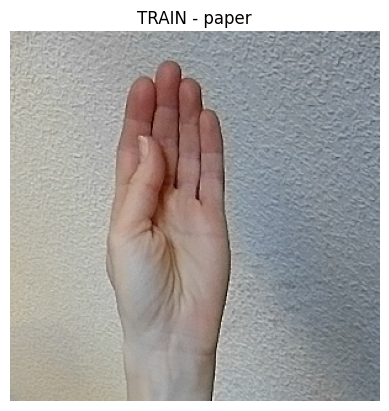

-->train, Class: rock, Image: archive/rock/rock_20.png, Shape: (300, 300, 3)


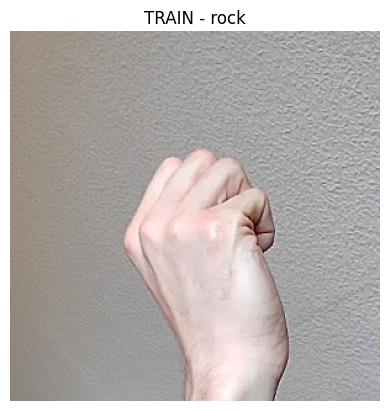

-->train, Class: scissors, Image: archive/scissors/scissors_886.png, Shape: (300, 300, 3)


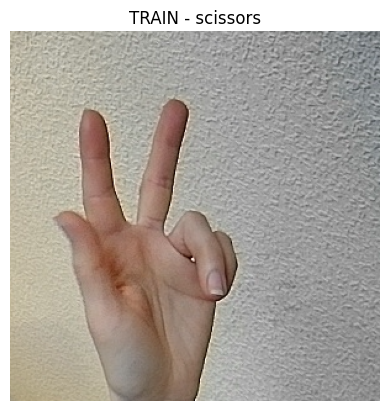


<--- DEVTEST SET --->
-->devtest, Class: rock, Image: archive/rock/rock_353.png, Shape: (300, 300, 3)


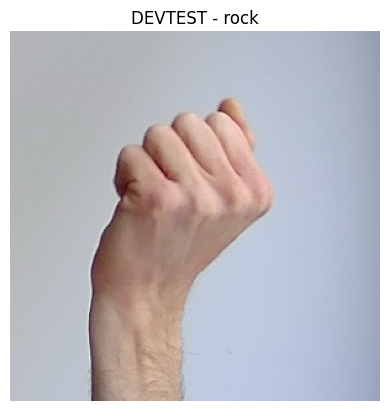

-->devtest, Class: scissors, Image: archive/scissors/scissors_211.png, Shape: (300, 300, 3)


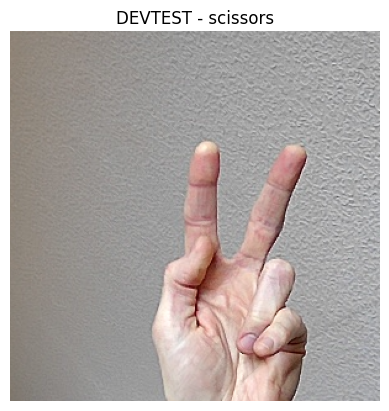

-->devtest, Class: paper, Image: archive/paper/paper_263.png, Shape: (300, 300, 3)


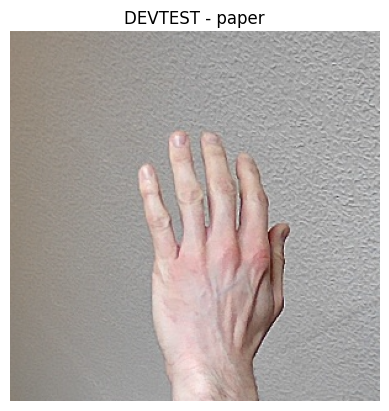


<--- TEST SET --->
-->test, Class: paper, Image: archive/paper/paper_343.png, Shape: (300, 300, 3)


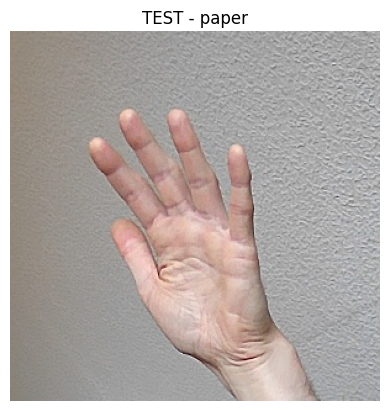

-->test, Class: rock, Image: archive/rock/rock_697.png, Shape: (300, 300, 3)


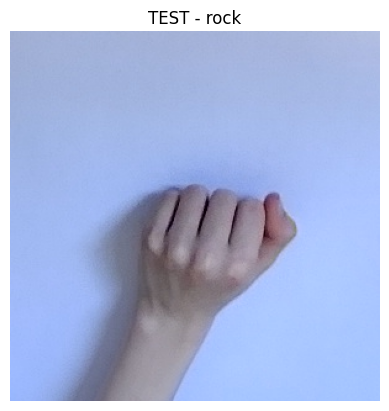

-->test, Class: scissors, Image: archive/scissors/scissors_764.png, Shape: (300, 300, 3)


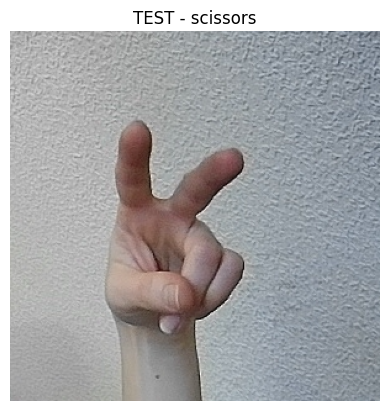


 Summary:

TRAIN SET:
  rock: 2 images (22.22%)
  paper: 6 images (66.67%)
  scissors: 1 images (11.11%)

DEVTEST SET:
  rock: 8 images (57.14%)
  paper: 1 images (7.14%)
  scissors: 5 images (35.71%)

TEST SET:
  rock: 1 images (25.00%)
  paper: 2 images (50.00%)
  scissors: 1 images (25.00%)


In [6]:
# this can be used to store class distribution for each set
#here the initialisation of the dictionary is done to store count of images for each class and dataset
class_counts = {}

# Looping through the each dataset
for name, df in datasets.items():
    print(f"\n<--- {name.upper()} SET --->")
    shown_classes = set()#used to check which classes have already one image displayed
    counts = Counter()#counts how many times each class appears

    #Looping through every row in dataset
    for _, row in df.iterrows():
        label = row['label']#class label
        img_path = f"{root_directory}/{row['path']}"  # Used string formatting

        img = cv2.imread(img_path)#Loading the image
        # if image is succesfully loaded we can print dataset name,class label ,full path of the image and the the shape of the image
        if img is not None:
            if label not in shown_classes:
                print(f"-->{name}, Class: {label}, Image: {img_path}, Shape: {img.shape}")
                shown_classes.add(label)
                #Process to display the image
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(f"{name.upper()} - {label}")
                plt.axis('off')
                plt.show()

                shown_classes.add(label)
        #Handling the error
        else:
            print(f" Unable to load image: {img_path}")

        counts[label] += 1
        if len(shown_classes) == 3:  # Only show one image per class
            break
    #Storing the count for the current dataset in the class_counts dictionary
    class_counts[name] = counts

# Printing the summary of the class distribution
print("\n Summary:")
for name, counts in class_counts.items():
    total = sum(counts.values())
    print(f"\n{name.upper()} SET:")
    #Looping through all the datasets abd prints the number of images abd proportion of the class in the particular dataset.
    for label in ['rock', 'paper', 'scissors']:
        count = counts[label]
        percent = (count / total) * 100
        print(f"  {label}: {count} images ({percent:.2f}%)")


Total number of images are 9 which means 3 for each category in each dataset

Also,Based on the output above my interpreation is that the proportions are not balanced .
because,each class should be having 33.3% approximately inorder to balance but in our case the paper dominates in train dataset,Rock dominates in devtest dataset and Scissors is very much low in the train dataset

This may make the model underperform and get biased and this may be solved by re splitting the images or even by adding more images to the dataset

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image#can be used to open image files

# Defining the image transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),   # Resize to 100x100,making sure all the images are of same size
    transforms.ToTensor()            # Converts image to tensor and used to scale pixel values to 0 to 1)
])

# this class is inherited from torch.utils.data.Dataset and used to load and access the image-label data
class RPSDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(self.data['label'].unique())#List that contains the class names
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}#Mapping the labels and numbers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = f"{self.root_dir}/{self.data.iloc[idx]['path']}"
        image = Image.open(img_path).convert('RGB')  # Opens and converts to RGB
        label = self.class_to_idx[self.data.iloc[idx]['label']]#Converts the label to images
        if self.transform:
            image = self.transform(image)
        return image, label


In [8]:
# Image directory (same as used in earlier code)
image_rootDirectory = "archive"

# assigning the paths to a variable
train_csv = "train.csv"
devtest_csv = "devtest.csv"
test_csv = "test.csv"

# Creating the objects for datsets
train_dataset = RPSDataset(train_csv, image_rootDirectory, transform)
devtest_dataset = RPSDataset(devtest_csv, image_rootDirectory, transform)
test_dataset = RPSDataset(test_csv, image_rootDirectory, transform)

# Creating the dataloaders
#Batch uses a standard 32 samples at a time
#Also shuffle is made true for only training inorder help the model generalize better
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Dataloaders are successfully created!")


Dataloaders are successfully created!


### Task 2-Classification

The model architecture is in such a way that it has two convolutional blocks with increasing filters(16 to 32) and pooling layers
Also,i used early stoppping process inorder to avoid overfitting
the Max pooling reduces dimensionality and the ReLU adds non Linearity

In [9]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Converts (3, 100, 100) to (16, 100, 100)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          

    nn.Conv2d(16, 32, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                          

    nn.Flatten(),                               
    nn.Linear(32 * 25 * 25, 128),                # Hidden 
    nn.ReLU(),
    nn.Dropout(0.3),                             #Droput is used for regularization
    nn.Linear(128, 3)                            # Output layer which has 3 classes(rock,paper and scissors)
)


Adam optimizer is used so that it adapts the learning rate during the training process

In [10]:
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() #Usually used for multi class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
num_epochs = 30
train_accuracy_list = []
val_accuracy_list = []
best_val_accuracy = 0    #for tracking the best accuracy till then.
patience = 5    #used to stop training if the accuracy of devtest doesnot improve after 5 epochs
epochs_no_improve = 0

In [12]:
for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_accuracy_list.append(train_accuracy)

    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, DevTest Acc: {val_accuracy:.4f}")

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_not_improving = 0
        torch.save(model.state_dict(), "best-model.pth")
    else:
        epochs_not_improving += 1
        if epochs_not_improving >= patience:
            print("Early stopping triggered.")
            break
        #If the accuracy does not improve the trainins will stop early and the best model will be saved.

Epoch [1/30], Train Acc: 0.3591, DevTest Acc: 0.3967
Epoch [2/30], Train Acc: 0.5777, DevTest Acc: 0.6384
Epoch [3/30], Train Acc: 0.7219, DevTest Acc: 0.7546
Epoch [4/30], Train Acc: 0.7778, DevTest Acc: 0.8192
Epoch [5/30], Train Acc: 0.8281, DevTest Acc: 0.8303
Epoch [6/30], Train Acc: 0.8631, DevTest Acc: 0.8561
Epoch [7/30], Train Acc: 0.9006, DevTest Acc: 0.9096
Epoch [8/30], Train Acc: 0.9282, DevTest Acc: 0.9004
Epoch [9/30], Train Acc: 0.9441, DevTest Acc: 0.9188
Epoch [10/30], Train Acc: 0.9398, DevTest Acc: 0.9280
Epoch [11/30], Train Acc: 0.9583, DevTest Acc: 0.9428
Epoch [12/30], Train Acc: 0.9681, DevTest Acc: 0.9410
Epoch [13/30], Train Acc: 0.9705, DevTest Acc: 0.9465
Epoch [14/30], Train Acc: 0.9797, DevTest Acc: 0.9373
Epoch [15/30], Train Acc: 0.9853, DevTest Acc: 0.9594
Epoch [16/30], Train Acc: 0.9632, DevTest Acc: 0.9446
Epoch [17/30], Train Acc: 0.9797, DevTest Acc: 0.9317
Epoch [18/30], Train Acc: 0.9773, DevTest Acc: 0.9520
Epoch [19/30], Train Acc: 0.9896, Dev

The training accuracy starts around 35% and increases almost to 99% also the devtest follows the similar trend which stops at 96% i observe no extreme gap between these two.

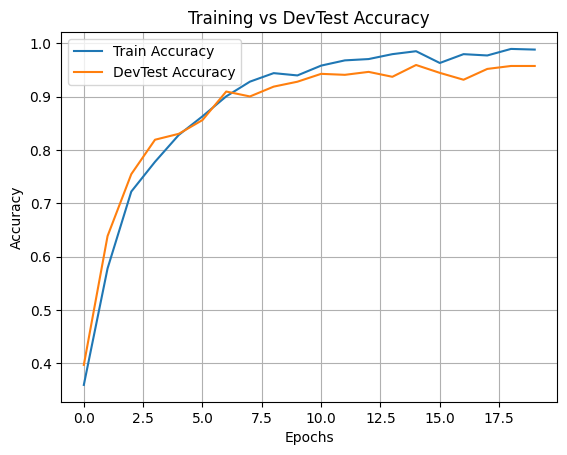

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(val_accuracy_list, label='DevTest Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs DevTest Accuracy")
plt.legend()
plt.grid(True)
plt.show()
#This graph helps to understand and visulaize overfitting or underfitting

The CNN model was trained on only 19 epochs,due to early stopping which is based on the validation accuracy
No significant overfitting 
The validation curve is smooth and tracks the training curve which shows a sign of stable learning
In our case early stopping helped in avoiding the graph go too foar and overfitting

In [14]:
# Loading the best model
model.load_state_dict(torch.load("best-model.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f" Final testing Accuracy: {test_acc:.4f}")


 Final testing Accuracy: 0.9707


The model performs very well on the unseen data.

In [ ]:
from torchvision import models


# Load MobileNetV2 with pretrained ImageNet weights
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)


# Freeze all layers(to make sure not to update the weights during training)
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the classifier head so that we only train new classifier head
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 3)  # three classes: rock, paper, scissors
mobilenet = mobilenet.to(device)

In [ ]:
#Defining the loss function and Optimiser
#Cross entropy is for stand multi class classification and adam mostly works well in the case of transfer learning
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.classifier.parameters(), lr=0.001)  # Only train classifier


In [21]:
#following the same process as before for this model
number_of_epochs = 30
train_acc_list = []
val_acc_list = []
best_val_acc = 0
patience = 5
epochs_no_improve = 0

for epoch in range(number_of_epochs):
    mobilenet.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)

    # Validation loop
    mobilenet.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{number_of_epochs}], Train Acc: {train_acc:.4f}, DevTest Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(mobilenet.state_dict(), "best-mobilenet.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


Epoch [1/30], Train Acc: 0.9540, DevTest Acc: 0.9557
Epoch [2/30], Train Acc: 0.9417, DevTest Acc: 0.9557
Epoch [3/30], Train Acc: 0.9583, DevTest Acc: 0.9520
Epoch [4/30], Train Acc: 0.9546, DevTest Acc: 0.9631
Epoch [5/30], Train Acc: 0.9613, DevTest Acc: 0.9613
Epoch [6/30], Train Acc: 0.9613, DevTest Acc: 0.9502
Epoch [7/30], Train Acc: 0.9552, DevTest Acc: 0.9613
Epoch [8/30], Train Acc: 0.9675, DevTest Acc: 0.9613
Epoch [9/30], Train Acc: 0.9650, DevTest Acc: 0.9686
Epoch [10/30], Train Acc: 0.9619, DevTest Acc: 0.9594
Epoch [11/30], Train Acc: 0.9607, DevTest Acc: 0.9594
Epoch [12/30], Train Acc: 0.9632, DevTest Acc: 0.9557
Epoch [13/30], Train Acc: 0.9601, DevTest Acc: 0.9649
Epoch [14/30], Train Acc: 0.9540, DevTest Acc: 0.9668
Early stopping triggered


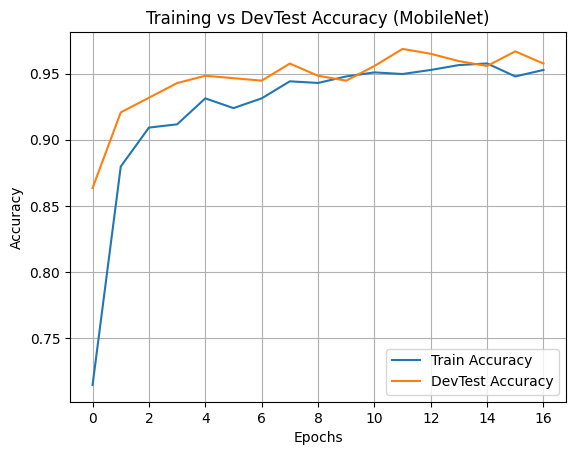

In [18]:
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="DevTest Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs DevTest Accuracy (MobileNet)")
plt.legend()
plt.grid(True)
plt.show()


The training accuracy increases rapidly in the first few epochs and then remains around 95 but the the devtest accuracy quickly raises and remains high around 96
Both the curves are very close but some epochs has the devtest accuracy exceeding the training accuracy this is a normal occurence may be due to randomness or augmentation

The modle is learning very well both the accuraies are high and stable
This shows that the model generalizes well and doesnot just memorize the training data and also there is no significant overfitting as the gap between the training and validation is minimal throughout

In [22]:
mobilenet.load_state_dict(torch.load("best_mobilenet.pth"))
mobilenet.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f" Final Test Accuracy (MobileNet): {test_acc:.4f}")


 Final Test Accuracy (MobileNet): 0.9652


The modle also performs very well on the unseen data,this learning was very effective and the overfitting was aslso controlled.

#### Comparitive evaluation
* There is a slight risk of overfitting after the epoch 17 for the first cnn model we implemented but for the MobileNetV2 model the overfitting is very minimal and the curves stayed very tight.
* The Maximum accuracy that i observed is 97.07 for test set of CNN model but it was 96.52 % for the MobileNetV2.
* the CNN model is slower in training the early epochs and the MobileNetV2 is fast in learning
* The CNN model was trained upto 19 epochs but the MobileNetV2 model trained only upto 17 epochs
Bothe the systems performed well and almost reached the similar accuracy but the MobileNetV2 was faster and learned in few epchs comparitively

In [24]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 6.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 13.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


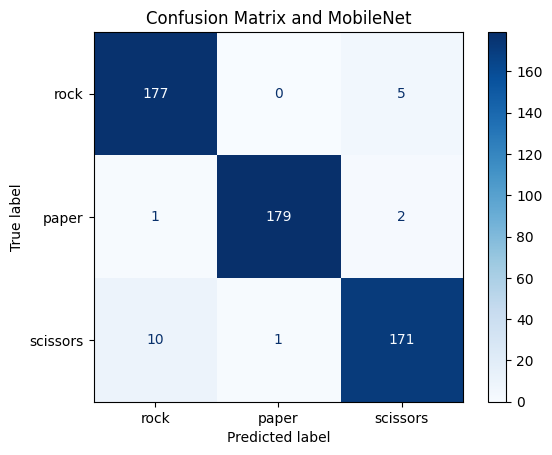

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluating the best model on test set
mobilenet.load_state_dict(torch.load("best-mobilenet.pth"))
mobilenet.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rock', 'paper', 'scissors'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix and MobileNet")
plt.show()


The confusion matrix very good performance however the scissors are misclassified as the rock for 10 times,This is the most common type of classification error reported by the confusion matrix
These errors are might be due to similarity in visual features such as brightness or orientation of hap shapes etc

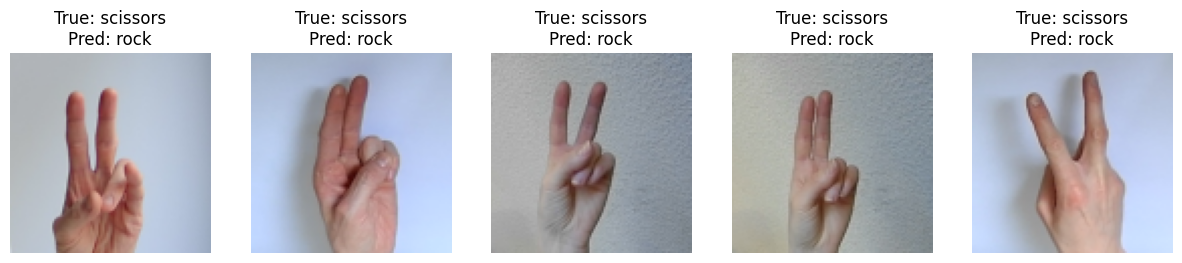

In [ ]:
class_names = ['rock', 'paper', 'scissors']
error_images = []

mobilenet.eval()
with torch.no_grad():      #diisabling the gradient tracking for faster and usage of less memory
    for images, labels in test_loader:
        images_gpu = images.to(device)
        outputs = mobilenet(images_gpu) #predicting the classs scores
        _, preds = torch.max(outputs, 1)
        
        for img, true, pred in zip(images, labels, preds.cpu()):
            if true == 2 and pred == 0:  
                error_images.append((img, true, pred))
            if len(error_images) == 5:
                break
        if len(error_images) == 5:  #only 5 images are to be printed
            break

# Plotting
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (img, label, pred) in enumerate(error_images):
    img = img.permute(1, 2, 0).numpy()      
    axs[i].imshow(img)  #Displaying the image
    axs[i].axis('off')
    axs[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
plt.show()


In [54]:
import os

#Creating a folder where all the images will get saved
output_dir = "data_from_webcam"
classes = ['rock', 'paper', 'scissors']
images_per_class = 100
camera_index = 0  # 0 = default webcam

# Creating the output folders and also making sure that it prevents the errors if in case the folders already exist
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# Opening the webcam
cap = cv2.VideoCapture(camera_index)
#checking if the web cam is opened correctly else an error message will be printed
if not cap.isOpened():
    print("Sorry mate! unable to open the webcam.")
else:
    print("Webcam is opened successfully")

try:
    #Looping over each class by starting the count wiith zero
    for cls in classes:
        print(f"\nCapturing for class: {cls}")
        count = 0

        while count < images_per_class:
            ret, frame = cap.read()#This is used to read the frames and save images
            if not ret:
                print("i am unable to capture the frame")
                break

            frame = cv2.resize(frame, (300, 300))
            label_text = f"{cls} | Image {count+1}/{images_per_class}"
            cv2.putText(frame, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imshow("Webcam - Press 's' to save, 'q' to quit", frame)

            key = cv2.waitKey(1)
            #Assigning the control keys inorder to operate the webcam
            if key == ord('s'):
                path = os.path.join(output_dir, cls, f"{cls}_{count}.png")
                cv2.imwrite(path, frame)
                print(f"Saved: {path}")
                count += 1

            elif key == ord('q') or key == 27:
                print("Manual exit triggered")
                cap.release()
                exit()
        cv2.destroyAllWindows()
    print("\n All images are captured,Thank you")
finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam is now closed.")


Webcam is opened successfully

Capturing for class: rock
Saved: data_from_webcam/rock/rock_0.png
Saved: data_from_webcam/rock/rock_1.png
Saved: data_from_webcam/rock/rock_2.png
Saved: data_from_webcam/rock/rock_3.png
Saved: data_from_webcam/rock/rock_4.png
Saved: data_from_webcam/rock/rock_5.png
Saved: data_from_webcam/rock/rock_6.png
Saved: data_from_webcam/rock/rock_7.png
Saved: data_from_webcam/rock/rock_8.png
Saved: data_from_webcam/rock/rock_9.png
Saved: data_from_webcam/rock/rock_10.png
Saved: data_from_webcam/rock/rock_11.png
Saved: data_from_webcam/rock/rock_12.png
Saved: data_from_webcam/rock/rock_13.png
Saved: data_from_webcam/rock/rock_14.png
Saved: data_from_webcam/rock/rock_15.png
Saved: data_from_webcam/rock/rock_16.png
Saved: data_from_webcam/rock/rock_17.png
Saved: data_from_webcam/rock/rock_18.png
Saved: data_from_webcam/rock/rock_19.png
Saved: data_from_webcam/rock/rock_20.png
Saved: data_from_webcam/rock/rock_21.png
Saved: data_from_webcam/rock/rock_22.png
Saved: dat

In [ ]:
import glob
import random

def partition_webcam_images(base_dir="data_from_webcam", output_dir=".", classes=['rock', 'paper', 'scissors']):
    partitions = {'train': [], 'devtest': [], 'test': []}
    #creation of empty list to store imgpath,label as tuples for each set.
    for cls in classes:
        paths = glob.glob(f"{base_dir}/{cls}/*.png") #glob is used to find all the png files
        random.shuffle(paths)

        partitions['train'] += [(os.path.relpath(p, base_dir), cls) for p in paths[:50]]
        partitions['devtest'] += [(os.path.relpath(p, base_dir), cls) for p in paths[50:75]]
        partitions['test'] += [(os.path.relpath(p, base_dir), cls) for p in paths[75:100]]
        #Splitting each class into 50 images for training,25 images for devtest and 25 images for test
    for split in ['train', 'devtest', 'test']:
        df = pd.DataFrame(partitions[split], columns=['path', 'label'])
        df.to_csv(f"{output_dir}/{split}.csv", index=False)#saving each partition to csv




Set: train.csv, Class: paper, Image shape: (300, 300, 3)


[ WARN:0@52595.975] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_770.png'): can't open/read file: check file path/integrity
[ WARN:0@52595.975] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_721.png'): can't open/read file: check file path/integrity


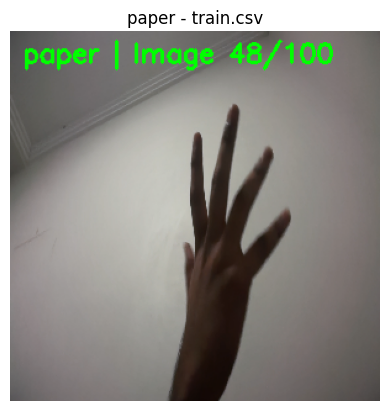

Set: train.csv, Class: rock, Image shape: (300, 300, 3)


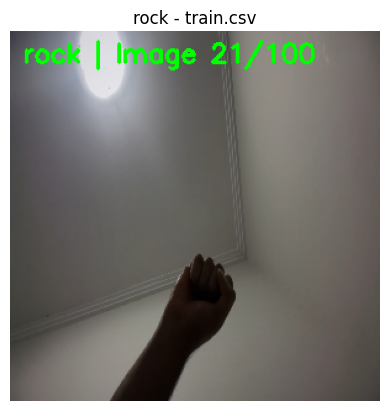

Set: train.csv, Class: scissors, Image shape: (300, 300, 3)


[ WARN:0@52596.043] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/scissors/scissors_886.png'): can't open/read file: check file path/integrity


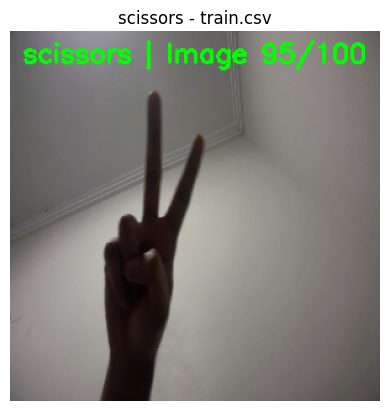

Set: devtest.csv, Class: scissors, Image shape: (300, 300, 3)


[ WARN:0@52596.071] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_353.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.071] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/scissors/scissors_211.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.071] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_198.png'): can't open/read file: check file path/integrity


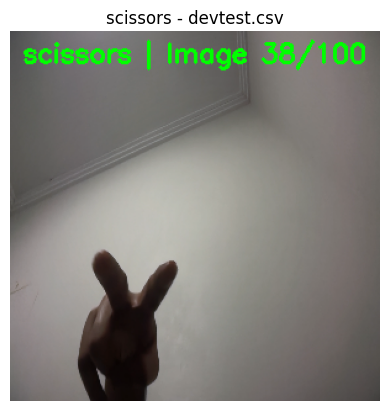

Set: devtest.csv, Class: rock, Image shape: (300, 300, 3)


[ WARN:0@52596.098] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_605.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.098] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_273.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.098] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_670.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.098] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_275.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.098] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_557.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.098] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_735.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.099] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_

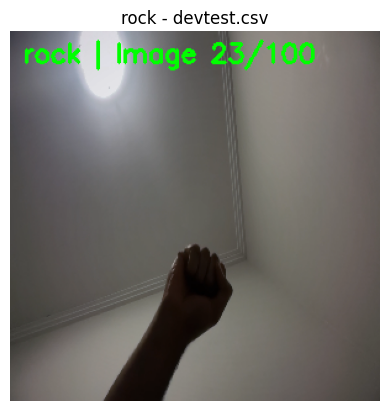

Set: devtest.csv, Class: paper, Image shape: (300, 300, 3)


[ WARN:0@52596.127] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_186.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.128] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_814.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.128] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_668.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.128] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_151.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.128] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_586.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.128] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_164.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.128] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/

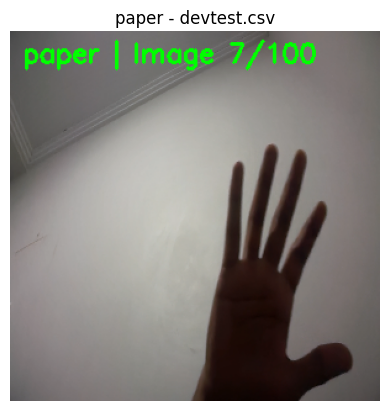

[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_343.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_697.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_489.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/scissors/scissors_764.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/scissors/scissors_251.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/scissors/scissors_172.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.156] global loadsave.cpp:268 findDecoder imread_('d

Set: test.csv, Class: scissors, Image shape: (300, 300, 3)


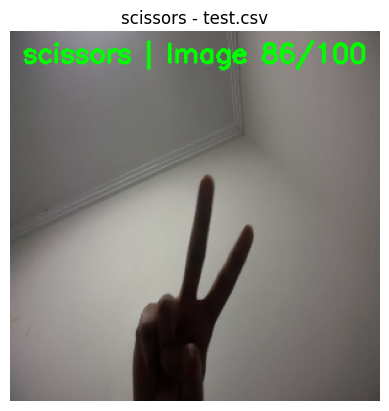

Set: test.csv, Class: paper, Image shape: (300, 300, 3)


[ WARN:0@52596.182] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_621.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.182] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_331.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.183] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_788.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.183] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_807.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.183] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/paper/paper_890.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.183] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_272.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.183] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/pape

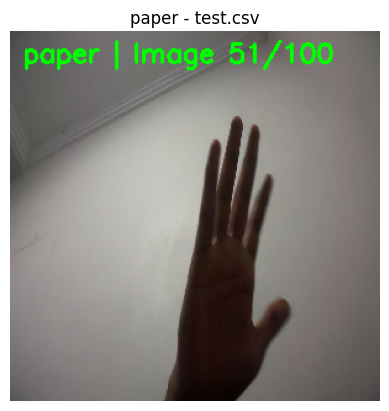

Set: test.csv, Class: rock, Image shape: (300, 300, 3)


[ WARN:0@52596.214] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_247.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.214] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_491.png'): can't open/read file: check file path/integrity
[ WARN:0@52596.214] global loadsave.cpp:268 findDecoder imread_('data_from_webcam/rock/rock_132.png'): can't open/read file: check file path/integrity


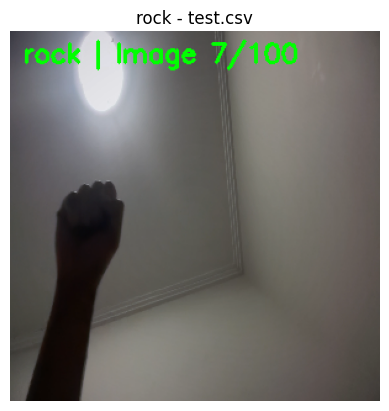

In [61]:
#Displaying one sample image per class 
def show_image_samples(csv_path, base_dir="data_from_webcam"):
    import pandas as pd
    df = pd.read_csv(csv_path)
    shown = set()#shown makes sure one image per class is displayed

    for _, row in df.iterrows():
        label = row['label']
        if label in shown:
            continue

        img_path = os.path.join(base_dir, row['path'])
        img = cv2.imread(img_path)
        if img is not None:
            print(f"Set: {os.path.basename(csv_path)}, Class: {label}, Image shape: {img.shape}")
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#this is due to difference between the opencv and matplotlib in reading BGR-RGB

            plt.imshow(img_rgb)
            plt.title(f"{label} - {os.path.basename(csv_path)}")
            plt.axis('off')
            plt.show()

            shown.add(label)
        if len(shown) == 3:
            break
show_image_samples("train.csv")
show_image_samples("devtest.csv")
show_image_samples("test.csv")


Finally i tested the best model from Task2 MobileNetV2 on the new test set, but for both before and after fine-tuning and also retested the fine tune model on the original test set.

In [110]:
from torchvision import models
import torch.nn as nn
#Loading teh MobileNetV2 pretrained model
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze all the other layers so that only the classifier is trainable
for param in mobilenet.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 3)  # total 3 output classes
mobilenet.load_state_dict(torch.load("best-mobilenet.pth"))  
mobilenet = mobilenet.to(device)
mobilenet.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [111]:
#This function is implemented to partition new webcam data and save the csv's
def partition_webcam_images(base_dir="data_from_webcam", output_dir=".", classes=['rock', 'paper', 'scissors']):
    partitions = {'train': [], 'devtest': [], 'test': []}

    for cls in classes:
        paths = glob.glob(f"{base_dir}/{cls}/*.png")
        random.shuffle(paths)

        partitions['train'] += [(os.path.relpath(p, base_dir), cls) for p in paths[:50]]#total 50 for training
        partitions['devtest'] += [(os.path.relpath(p, base_dir), cls) for p in paths[50:75]]#total 25 for devtest
        partitions['test'] += [(os.path.relpath(p, base_dir), cls) for p in paths[75:100]]#total 25 for testing

    for split in ['train', 'devtest', 'test']:
        df = pd.DataFrame(partitions[split], columns=['path', 'label'])
        df.to_csv(f"{output_dir}/{split}.csv", index=False)
        print(f"{split}.csv created with {len(df)} entries.")

# Run this once to overwrite old CSVs
partition_webcam_images()


train.csv created with 150 entries.
devtest.csv created with 75 entries.
test.csv created with 75 entries.


In [112]:
#This function is created to measure classification accuracy of the model
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [113]:
webcam_train = RPSDataset("train.csv", "data_from_webcam", transform)
webcam_devtest = RPSDataset("devtest.csv", "data_from_webcam", transform)
webcam_test = RPSDataset("test.csv", "data_from_webcam", transform)

webcam_train_loader = DataLoader(webcam_train, batch_size=32, shuffle=True)
webcam_devtest_loader = DataLoader(webcam_devtest, batch_size=32)
webcam_test_loader = DataLoader(webcam_test, batch_size=32)

original_test = RPSDataset("test.csv", "archive", transform)
original_test_loader = DataLoader(original_test, batch_size=32)


In [121]:
acc_before = evaluate(mobilenet, webcam_test_loader)
print(f" Accuracy on webcam test set (before fine-tuning): {acc_before:.4f}")


 Accuracy on webcam test set (before fine-tuning): 0.9200


Looks like the model have achieved 0.9200 without any fine tuning.
this shows that the pre trained model generalizes very well to the webcam images even though there is difference in lightning,backgrounds,etc...

##### Fine tuning the model on webcam train and devtest

In [120]:
#now we have to unfreeze the classifier for retraining 
for param in mobilenet.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.classifier.parameters(), lr=0.001)
# combining the datasets for better generalization
from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([webcam_train, webcam_devtest])
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

mobilenet.train()
for epoch in range(10):
    correct, total = 0, 0
    for images, labels in combined_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}, Train Accuracy: {correct / total:.4f}")


Epoch 1, Train Accuracy: 0.9378
Epoch 2, Train Accuracy: 0.9111
Epoch 3, Train Accuracy: 0.9556
Epoch 4, Train Accuracy: 0.9422
Epoch 5, Train Accuracy: 0.9600
Epoch 6, Train Accuracy: 0.9644
Epoch 7, Train Accuracy: 0.9600
Epoch 8, Train Accuracy: 0.9689
Epoch 9, Train Accuracy: 0.9733
Epoch 10, Train Accuracy: 0.9556


i have used 10 epochs and looks like the model accuracy is being increased for each epoch during training..

The model is now fine tuned using 75 webcam images(train and devtest)

after finetuning the model the accuracy reached upto 97.33%,this type of adaption improved the models understanding of these webcam images

In [122]:
original_test_dataset = RPSDataset("original_test.csv", "archive", transform)
original_test_loader = DataLoader(original_test_dataset, batch_size=32)

acc_after_original = evaluate(mobilenet, original_test_loader)
print(f"Accuracy on original test set after finetuning: {acc_after_original:.4f}")


Accuracy on original test set after finetuning: 0.5500


After finetuning the model and evaluated with the original dataset my models accuracy dropped to 55% which shows overfitting to the webcam data 
this leads to a conclusion that the performance may be degrading for the model in the original domain if there is over-specialization in the new one...